In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from preprocessing import encoding_sorted, encode_one_hot, prepare_existing_data, download_raw_data
from charts_and_write import *


# Random Forest Classifier

Este algortimo tiene un conjunto de arboles de decisión en donde cada arbol usa un botostrap del set de entrenamiento y un conjunto de features al azar. Los principales hiperparametros son la cantidad de arboles (estimators) a crear y cuantos atributos tiene cada uno

## Preprocesamiento

En nuestro script preprocessing.py tenemos definidas ya funciones que nos van a servir para descargar los datos crudos y luego prepararlos para luego poder aplicarle ingeniería de features. La función prepararDatosExistentes 

In [44]:
download_raw_data()

In [45]:
#datasets train-test y holdout 
data_train = pd.read_csv("impuestos_train.cvs")
data_holdout = pd.read_csv("impuestos_holdout.cvs")
#llenamos los nulls y borramos columnas que no se usan
data_train, data_holdout = prepare_existing_data(data_train, data_holdout)


## Selección de features 1


Podemos usar los features que ya vienen en el dataset y ademas generar nuevos a partir de ellos. Para empezar de entrada vamos a descartar algunos que ya en el TP1 vimos que no aportaban como son barrio y educacion alcanzada. 
Luego, de los features ya existentes va a haber un grupo, los categoricos, que al no ser numericos vamos a tener que utilizar un encodeo para poder entrenar el modelo. La mayoria de ellos no tienen un orden entonces vamos a usar nuestra función de one hot encoding, que genera una columna nueva por cada valor posible. Para el caso de los que sí tienen orden vamos a utilizar un encodeo propio con la funcion "encoding_sorted". Ambas funciones estan en el script de preprocessing.py.


In [46]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_train_v1 = encode_one_hot(data_train, columns_one_hot)
columns_sorted_numeric = ["educacion"]
data_train_v1 = encoding_sorted(data_train_v1, columns_sorted_numeric)


In [47]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(data_train_v1.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v1["tiene_alto_valor_adquisitivo"], random_state=42)

## Selección de features 2

Para la segunda selección vamos a agregar features obtenidos a partir del analisis del TP1, que son la transformación de edad a decil y de gancnaias en bolsa a cuartil.
El feature edad lo vamos a reemplazar por el decil al que pertenece en el dataset de entrenamiento, y vamos a reemplazar el feature de ganancias y perdidas en la bolsa por uno "bolsa" que representará el cuartil al que pertenece, en caso de ganancia, 0 en caso de no tener actividad, y un valor negativo correspondiente al cuartil en el caso de perdidas. Así, los casos que mas perdida tienen van a tener el valor -4, y los que mas ganancia tienen van a tener el valor 4.


In [48]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_train_v2 = encode_one_hot(data_train,columns_one_hot)
columns_sorted_numeric = ["educacion", "edad", "bolsa"]
data_train_v2 = encoding_sorted(data_train_v2, columns_sorted_numeric)


In [49]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(data_train_v2.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v2["tiene_alto_valor_adquisitivo"], random_state=42)

## Prueba rf por defecto

Vamos primero a correr un random forest con hiperparametros por defecto y ver como performa, así luego al hacer random y grid search

### Seleccion 1

In [50]:
clf = RandomForestClassifier()
clf.fit(X_train_v1, y_train_v1)
crossval_scores = cross_val_score(clf, X_train_v1, y_train_v1, scoring='roc_auc', cv=10)
results_cv = cross_validate(clf, X_train_v1, y_train_v1, cv=5, scoring=['precision', "recall", "accuracy", "roc_auc"])
show_cv_metrics(results_cv)
#metricas cross validation en train

Accuracy: 0.8444307944307944
----------------------------------------------
Precision: 0.7047866934187385
----------------------------------------------
Recall: 0.616165274267578
----------------------------------------------
Auc Roc score: 0.892111756017776
----------------------------------------------


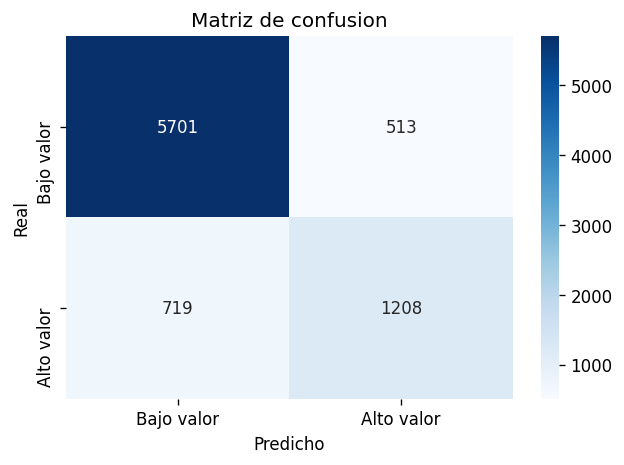

In [51]:
y_pred = clf.predict(X_test_v1)
show_confusion_matrix(y_pred,y_test_v1)

In [52]:
#metricas set de test

In [53]:
show_metrics(clf, y_pred, y_test_v1, X_test_v1 , "random forest")

Accuracy: 0.8486672398968186
----------------------------------------------
Precision: 0.6268811624286456
----------------------------------------------
Recall: 0.7019174898314933
----------------------------------------------
F1_score: 0.6622807017543859
----------------------------------------------
AUC-ROC score para random forest: 0.896


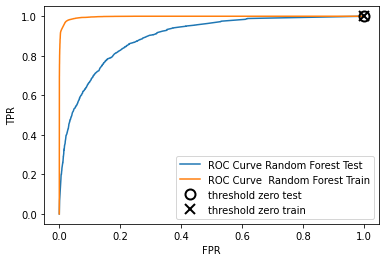

In [54]:
show_roc_curve(clf,"Random Forest",X_test_v1, X_train_v1, y_test_v1, y_train_v1)

### Seleccion 2

In [55]:
clf = RandomForestClassifier()
clf.fit(X_train_v2, y_train_v2)
crossval_scores = cross_val_score(clf, X_train_v2, y_train_v2, scoring='roc_auc', cv=10)
results_cv = cross_validate(clf, X_train_v2, y_train_v2, cv=5, scoring=['precision', "recall", "accuracy", "roc_auc"])
show_cv_metrics(results_cv)
#resultado metricas cross validation en set de train

Accuracy: 0.8479524979524979
----------------------------------------------
Precision: 0.7154545941804079
----------------------------------------------
Recall: 0.6185321381729035
----------------------------------------------
Auc Roc score: 0.8956169352496157
----------------------------------------------


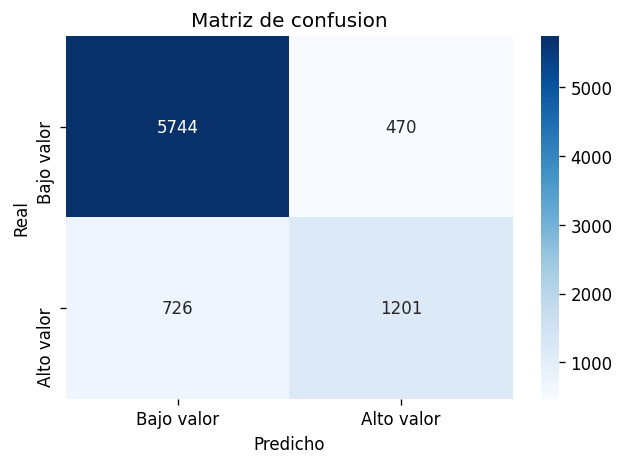

In [56]:
y_pred = clf.predict(X_test_v2)
show_confusion_matrix(y_pred,y_test_v2)

In [57]:
#resultado metricas test
show_metrics(clf, y_pred, y_test_v2, X_test_v2 , "random forest")

Accuracy: 0.8530893010686648
----------------------------------------------
Precision: 0.623248572911261
----------------------------------------------
Recall: 0.7187312986235787
----------------------------------------------
F1_score: 0.6675931072818232
----------------------------------------------
AUC-ROC score para random forest: 0.896


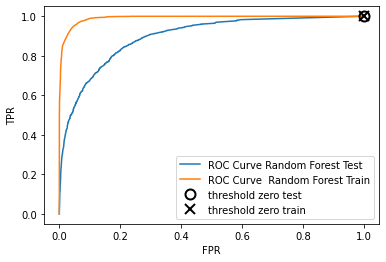

In [58]:
show_roc_curve(clf,"Random Forest",X_test_v2, X_train_v2, y_test_v2, y_train_v2)

Podemos ver que con la segunda selección todas las metricas mejoran pero muy poco. Que pasa si mejoramos los hiperparametros?

## Buscamos los mejores rangos de hiperparametros con Randomized Search Cross Validation y Grid Search para ambas selecciones

### Randomized Search Cross Validation Seleccion 1


Vamos a utilizar randomized search para buscar el rango de valores posibles para hiperparametros para luego hacer un grid search.

In [59]:
param_random = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
               'min_samples_split': [2, 3, 4, 5, 6, 7],
               'min_samples_leaf': [2, 3, 4, 5, 6, 7]}

In [60]:
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(clf, param_distributions = param_random, random_state=0)
random_search.fit(X_train_v1, y_train_v1)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0)

In [61]:
random_search.best_params_

{'n_estimators': 800,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_depth': 9}

###  Grid Search Cross Validation Seleccion 1

Para el cross validation vamos a usar 5 folds. 
En el param grid usamos valores de hiperparametros cercanos a los obtenidos como best params en random search.
Para que el grid search decida cual es la mejor combinacion vamos a utilizar roc auc como metrica.

In [62]:
param_grid = {'n_estimators': [750, 800, 850],
               'max_depth': [None, 8, 9, 10],
               'min_samples_split': [3,4, 5, None],
               'min_samples_leaf': [2, 3, 4, None]}

In [63]:
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)

In [64]:
grid_search.fit(X_train_v1, y_train_v1)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, None],
                         'min_samples_split': [3, 4, 5, None],
                         'n_estimators': [750, 800, 850]},
             scoring='roc_auc')

In [65]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 850}


La mejor combinacion de hiperparametros para la seleccion 1 finalmente nos queda con min_samples_leaf = 3, min_samples_split_3 y 850 estimadores.

Ahora veamos para la seleccion 2

## Randomized Search Cross Validation Seleccion 2


In [66]:
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(clf, param_distributions = param_random, random_state=0)
random_search.fit(X_train_v2, y_train_v2)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0)

In [67]:
random_search.best_params_

{'n_estimators': 800,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_depth': 9}

### Grid Search Cross Validation Seleccion 2

En el param grid usamos valores de hiperparametros cercanos a los obtenidos como best params en random search.

In [68]:
param_grid = {'n_estimators': [750, 800, 850],
               'max_depth': [None, 8, 9, 10],
               'min_samples_split': [3,4, 5, None],
               'min_samples_leaf': [2, 3, 4, None]}

In [69]:
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)

In [70]:
grid_search.fit(X_train_v2, y_train_v2)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, None],
                         'min_samples_split': [3, 4, 5, None],
                         'n_estimators': [750, 800, 850]},
             scoring='roc_auc')

In [71]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 850}


## Probamos los resultados de grid search en nuestros datasets

### Seleccion 1

In [72]:
best_clf = RandomForestClassifier(max_depth=None,min_samples_leaf=4,min_samples_split=5,n_estimators=850)
best_clf.fit(X_train_v1, y_train_v1)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=850)

In [73]:
results_cv = cross_validate(best_clf, X_train_v1, y_train_v1, cv=5, scoring=['precision', "recall", "accuracy", "roc_auc"])
#metricas cross validation en set de train
show_cv_metrics(results_cv)

Accuracy: 0.8609336609336609
----------------------------------------------
Precision: 0.7656161754487456
----------------------------------------------
Recall: 0.6146445770811253
----------------------------------------------
Auc Roc score: 0.91669907050534
----------------------------------------------


Quedandonos con el promedio del resultado de cada fold nos quedan las 5 metricas principales con valores bastante mejores que el modelo con hiperparametros default

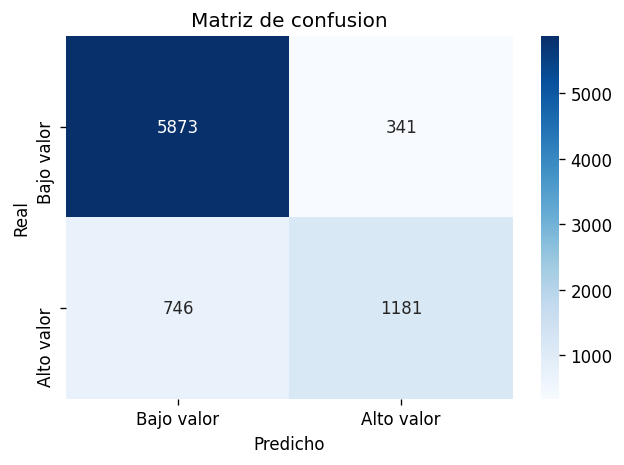

In [74]:
y_pred = best_clf.predict(X_test_v1)
show_confusion_matrix(y_pred,y_test_v1)

In [75]:
#como quedan las metricas en test?
show_metrics(best_clf, y_pred, y_test_v1, X_test_v1 , "random forest")

Accuracy: 0.8664783196167547
----------------------------------------------
Precision: 0.6128697457187338
----------------------------------------------
Recall: 0.7759526938239159
----------------------------------------------
F1_score: 0.6848361844012757
----------------------------------------------
AUC-ROC score para random forest: 0.918


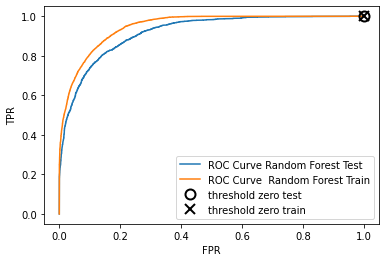

In [76]:
show_roc_curve(best_clf,"Random Forest",X_test_v1, X_train_v1, y_test_v1, y_train_v1)

### Selección 2

In [77]:
best_clf = RandomForestClassifier(max_depth=None,min_samples_leaf=3,min_samples_split=3,n_estimators=850)
best_clf.fit(X_train_v2, y_train_v2)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=3,
                       n_estimators=850)

In [78]:
results_cv = cross_validate(best_clf, X_train_v2, y_train_v2, cv=5, scoring=['precision', "recall", "accuracy", "roc_auc"])
#metricas cross validation en set de trian
show_cv_metrics(results_cv)

Accuracy: 0.8608108108108109
----------------------------------------------
Precision: 0.7681220077867312
----------------------------------------------
Recall: 0.6104180343930442
----------------------------------------------
Auc Roc score: 0.9173268457867998
----------------------------------------------


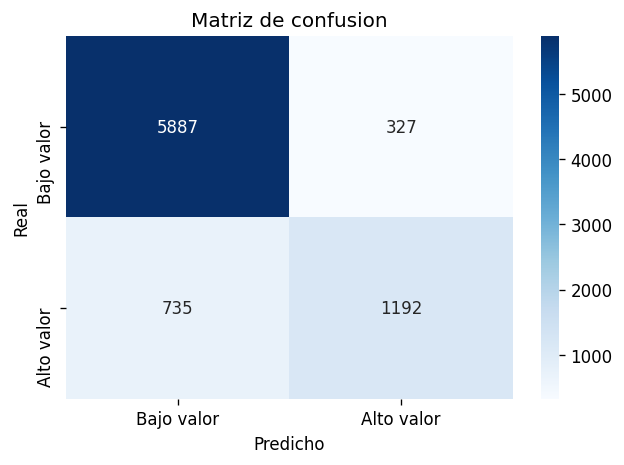

In [79]:
y_pred = best_clf.predict(X_test_v2)
show_confusion_matrix(y_pred,y_test_v2)

In [80]:
#como quedan las metricas en test?
show_metrics(best_clf, y_pred, y_test_v2, X_test_v2 , "random forest")

Accuracy: 0.8695491954305368
----------------------------------------------
Precision: 0.6185781006746238
----------------------------------------------
Recall: 0.7847267939433838
----------------------------------------------
F1_score: 0.6918165989553106
----------------------------------------------
AUC-ROC score para random forest: 0.919


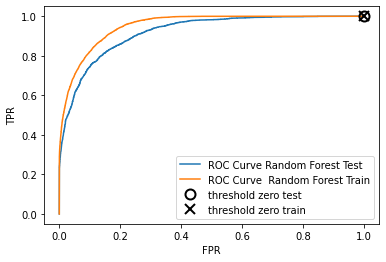

In [81]:
show_roc_curve(best_clf,"Random Forest",X_test_v2, X_train_v2, y_test_v2, y_train_v2)

### 

### Resultado

El modelo que mejor performó fue el que usaba la selección 2 de datos con los mejores hiperparametros obtenidos con gridsearch 

In [82]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
columns_sorted_numeric = ["educacion", "edad", "bolsa"]
data_holdout = encode_one_hot(data_holdout, columns_one_hot)
data_holdout = encoding_sorted(data_holdout, columns_sorted_numeric)

In [83]:
best_clf = RandomForestClassifier(max_depth=None,min_samples_leaf=3,min_samples_split=3,n_estimators=850)
best_clf.fit(X_train_v2, y_train_v2)
predictions_holdout = best_clf.predict(data_holdout.drop(columns='id'))

In [84]:
write_predictions (predictions_holdout,"random_forest",data_holdout["id"])
